In [47]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install sklearn
# %pip install tensorflow
#%pip install seaborn
#%pip install scikit-learn
#%pip install tqdm


In [48]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
#from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


In [49]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [50]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            split=klass.split(' ')
            label=''
            for i in range(2, len(split)):
                label=label + split[i]+' '            
            desc=f'{label:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())     
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir="D:\downlaods\Durum_Wheat_Dataset\Dataset2-Durum Wheat Video Images"
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)
    

Mixture of All Durum Wheat and Foreign Matters : 100%|█████████████████████████████████████████████████| 65/65 [00:00<?, ?files/s]
Mixture of All Durum Wheat and Foreign Matters (Labeled) : 100%|███████████████████████████████████████| 65/65 [00:00<?, ?files/s]


number of classes in processed dataset=  5
the maximum files in any class in train_df is  46   the minimum files in any class in train_df is  45
train_df length:  227   test_df length:  49   valid_df length:  49
average image height=  1088   average image width=  890  aspect ratio h/w=  1.2224719101123596


In [68]:
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')  # Directory to store augmented images
    
    # Remove the existing augmented directory if it exists
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    
    # Create class directories within the augmented directory
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        # Check if directory already exists
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)  # Make class directories within aug directory  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 


n=120 # number of samples in each class
working_dir="D:\Projects\Grain_Classifier\output" # directory to store augmented images"
img_size=(300, 280) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  

Initial length of dataframe is  600
Found 45 validated image filenames.      for class Mixture of All Durum Wheat and Foreign Matters (Labeled)  creating  75   augmented images 


Found 46 validated image filenames.      for class      Starchy Durum Wheat       creating  74   augmented images 
Found 46 validated image filenames.      for class Mixture of All Durum Wheat and Foreign Matters  creating  74   augmented images 
Found 45 validated image filenames.      for class        Foreign Matters         creating  75   augmented images 
Found 45 validated image filenames.      for class     Vitreous Durum Wheat       creating  75   augmented images 
Found 0 validated image filenames.       for class        Foreign Matters         creating  45   augmented images 


In [52]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 600 validated image filenames belonging to 10 classes.           for train generator 
Found 49 validated image filenames belonging to 5 classes.             for valid generator 
Found 49 validated image filenames belonging to 5 classes.             for test generator 
test batch size:  49   test steps:  1  number of classes :  10


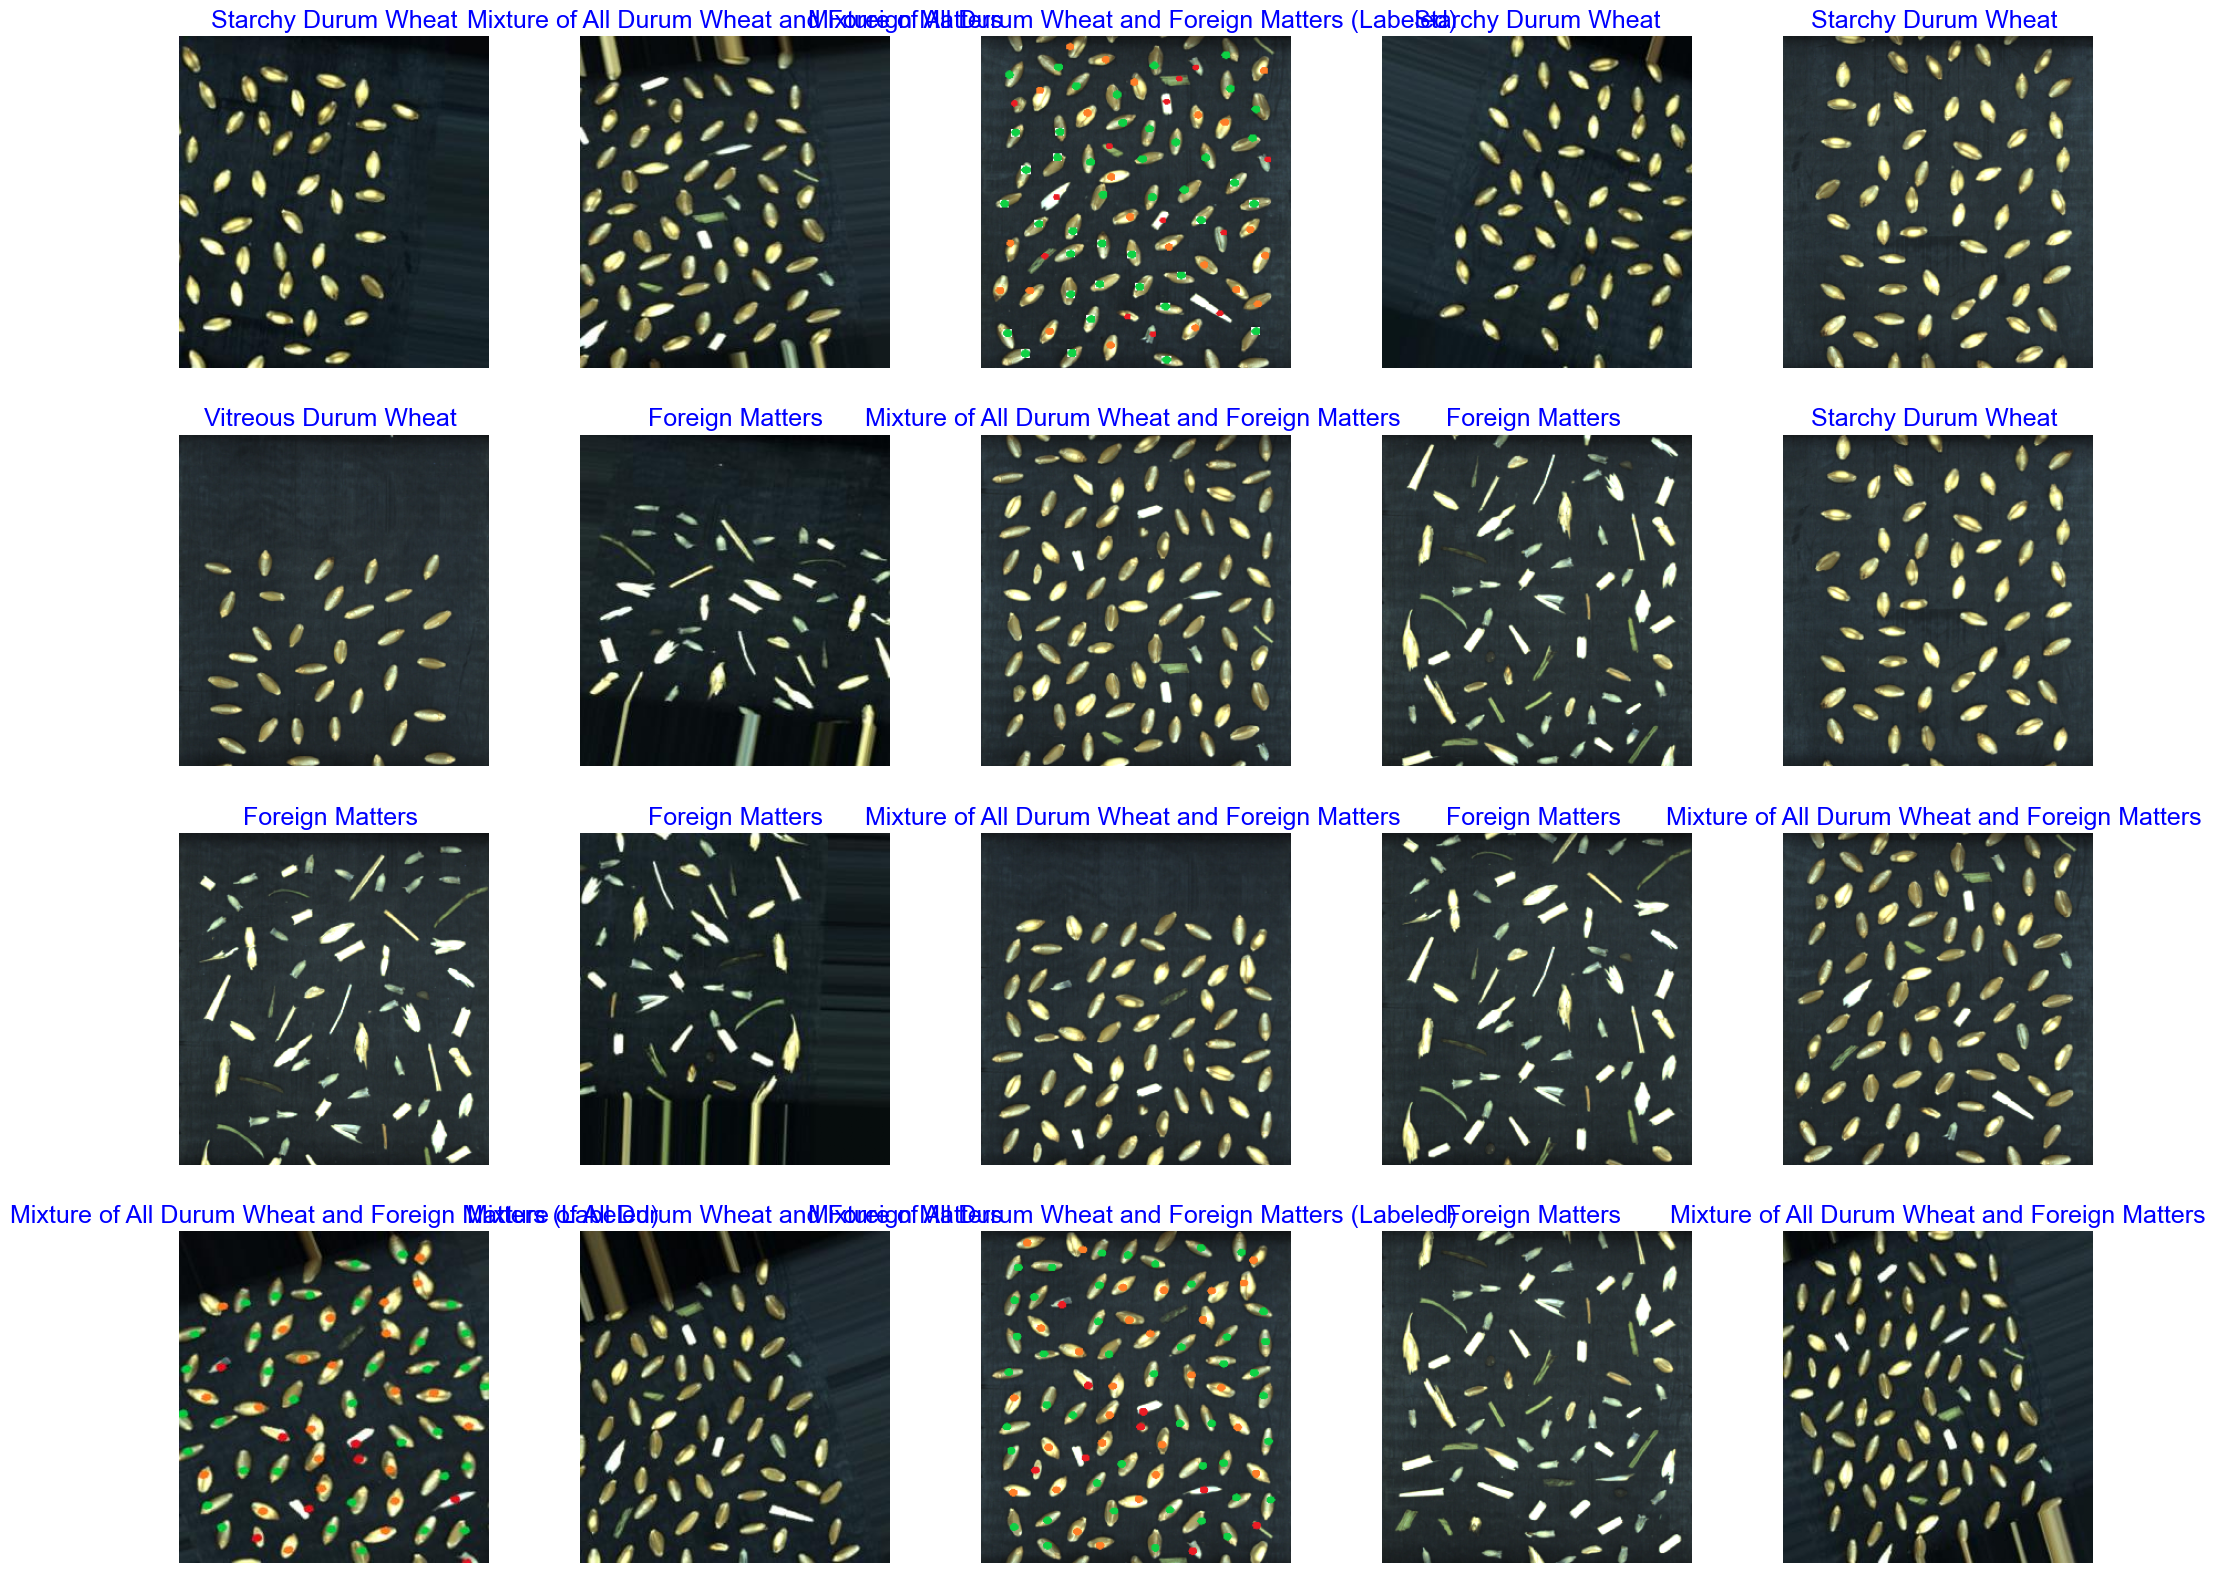

In [53]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

def make_custom_cnn_with_mlp(img_size, lr, class_count):
    img_shape = (img_size[0], img_size[1], 3)
    
    # Define the input
    inputs = Input(shape=img_shape)
    
    # Define the CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    
    # MLP Classifier with multiple Dense layers
    x = Dense(512, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.5, seed=123)(x)
    
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=0.5, seed=123)(x)
    
    output = Dense(class_count, activation='softmax')(x)
    


In [55]:
from tensorflow.keras.callbacks import Callback
class LR_ASK(Callback):
    def __init__(self, epochs, ask_epoch, dwell=True, factor=.4): 
        super(LR_ASK, self).__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        self.best_weights = None 
        self.best_epoch = 1
        self.plist = []
        self.alist = []
        self.dwell = dwell
        self.factor = factor
        
    def get_list(self):
        return self.plist, self.alist
    
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print(f'ask_epoch >= epochs, will train for {self.epochs} epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            msg = f'Training will proceed until epoch {self.ask_epoch} then you will be asked to' 
            print_in_color(msg)
            msg = 'enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg = 'Learning rate will be automatically adjusted during training'
                print_in_color(msg, (0, 255, 0))
        self.start_time = time.time()
       
    def on_train_end(self, logs=None):   
        msg = f'Loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0, 255, 255))
        self.model.set_weights(self.best_weights) 
        tr_duration = time.time() - self.start_time         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print_in_color(msg)
        
    def on_epoch_end(self, epoch, logs=None):  
        vloss = logs.get('val_loss')  
        aloss = logs.get('loss')
        if epoch > 0:
            deltav = self.lowest_vloss - vloss 
            pimprov = (deltav / self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa = self.lowest_aloss - aloss
            aimprov = (deltaa / self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov = 0.0 
            aimprov = 0.0
        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            self.best_weights = self.model.get_weights() 
            self.best_epoch = epoch + 1            
            msg = f'\nValidation loss of {vloss:7.4f} is {pimprov:7.4f}% below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0, 255, 0)) 
        else: 
            pimprov = abs(pimprov)
            msg = f'\nValidation loss of {vloss:7.4f} is {pimprov:7.4f}% above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255, 255, 0)) 
            if self.dwell: 
                lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
                new_lr = lr * self.factor
                msg = f'Learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) 
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) 
                self.model.set_weights(self.best_weights)      
                
        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss        
        if self.ask: 
            if epoch + 1 == self.ask_epoch:
                msg = '\nEnter H to end training or an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) 
                ans = input()
                
                if ans in ['H', 'h', '0']:
                    msg = f'You entered {ans}, Training halted on epoch {epoch + 1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True 
                else: 
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print(f'\nYou specified maximum epochs of {self.epochs}, cannot train for {self.ask_epoch}', flush=True)
                    else:
                        msg = f'You entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) 
                        if not self.dwell:
                            lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
                            msg = f'Current LR is {lr:8.6f} hit enter to keep this LR or enter a new LR'
                            print_in_color(msg) 
                            ans = input(' ')
                            if ans == '':
                                msg = f'Keeping current LR of {lr:7.5f}'
                                print_in_color(msg) 
                            else:
                                new_lr = float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                                msg = f'Changing LR to {ans}'
                                print_in_color(msg) 

In [56]:
from tensorflow.keras import layers, Model, regularizers
img_size = (300, 280)
lr = 0.001
class_count = 5  # Number of classes in your dataset
model = make_custom_cnn_with_mlp(img_size, lr, class_count)

epochs = 50  # Example number of epochs
ask_epoch = 10  # Example epoch to ask the user

# Initialize the callback
lr_ask_callback = LR_ASK(epochs, ask_epoch)
callbacks=[lr_ask_callback]

In [57]:
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[lr_ask_callback],  # Assuming you have other callbacks as well
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=True,  # It’s common to shuffle the dataset for training
    initial_epoch=0
)


AttributeError: 'NoneType' object has no attribute 'fit'